# ViT
(Vision Transformer)
## Replication of "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"
[Link to original paper](https://arxiv.org/abs/2010.11929)

(Versions of paper in different formats can be found on the right hands site)

<span style="color:magenta">Kudos</span> and a huge <span style="color:magenta">"thank you"</span> to Daniel Bourke (zerotomastery.io). Inspiration and basic instructions on how to approach the topic, at least for the first part, I took from him and applied it to a different dataset. In his famous series on "PyTorch for Deep Learning Bootcamp" he walks you step-by-step through replicating the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Daniel does a terrific and inspiring job in breaking down the core technical aspects of the paper, without digging too deep into the underlaying complex math, which deserves a bootcamp on its own.

## Setup

In [88]:
import torch

# Torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split

# Torchinfo
from torchinfo import summary

# Torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights

from pathlib import Path
from PIL import Image
import math

import pandas as pd
import matplotlib.pyplot as plt

#from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves
    
print(f"Torch\t\t{torch.__version__}")
print(f"Torchvision\t{torchvision.__version__}")

Torch		2.7.1
Torchvision	0.22.1


In [2]:
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Device\t\t{device}")

Device		mps


In [3]:
data_dir = Path("../projects/wafer-cnn/data/WM811k_Dataset")

# List the folders (each class)
categories = [d.name for d in data_dir.iterdir() if d.is_dir()]
print("Categories:", categories)

Categories: ['Donut', 'Center', 'near full', 'Local', 'Scratch', 'Edge Ring', 'Edge Local', 'random', 'none']


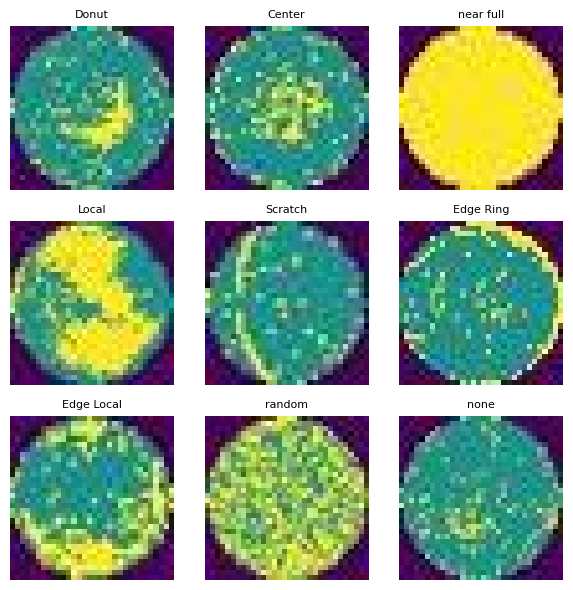

In [4]:
# Collect one image per category
images = []
titles = []

for category in categories:
    folder = data_dir / category
    image_files = list(folder.glob("*.jpg"))
    
    if not image_files:
        print(f"[!] No images found in {folder}")
        continue

    try:
        img = Image.open(image_files[0])
        images.append(img)
        titles.append(category)
    except Exception as e:
        print(f"[!] Could not open image from {folder}: {e}")

# Plotting: 3 images per row
n = len(images)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

# Flatten axes array and pad if needed
axes = axes.flatten()

# Plot images
for i in range(len(axes)):
    ax = axes[i]
    if i < n:
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i], fontsize=8)
    else:
        ax.axis('off')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Config

In [21]:
BATCH_SIZE = 32    # 
IMG_SIZE = 224     # num of pixels per axis per image
PATCH_SIZE = 16    # num of pixels per axis per patch
IN_CHANNELS = 3
OUT_CHANNELS = 768 # Hidden size D (= embedding size)

## Preprocessing

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print(transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [7]:
# Create Dataset
dataset = datasets.ImageFolder(
    root=str(data_dir),
    transform=transform
)
# DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0 # alternative: =2; =0 to be preferred on macOS, in case of multiprocessing issues
)

In [8]:
class_table = pd.Series(dataset.class_to_idx).sort_values().to_frame(name="class_to_idx")
class_table.index.name = "classes"

class_table

,class_to_idx
classes,
Center,0
Donut,1
Edge Local,2
Edge Ring,3
Local,4
Scratch,5
near full,6
none,7
random,8


In [9]:
# Sample batch
images, labels = next(iter(dataloader))
print("Image batch shape:", images.shape)   # [batch_size, channels, height, width]
print("Label batch shape:", labels.shape)

Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [10]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

print(f"Length of dataset\t{len(dataset)}")
print(f"Length of train_size\t{train_size}\t{train_size/len(dataset)*100:.2f}% of dataset")
print(f"Length of val_size\t{val_size}\t{val_size/len(dataset)*100:.2f}% of dataset")

Length of dataset	902
Length of train_size	721	79.93% of dataset
Length of val_size	181	20.07% of dataset


In [11]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Len: train_loader batch:\t{len(train_loader)}")
print(f"Len: val_loader batch:\t\t{len(val_loader)}")

Len: train_loader batch:	23
Len: val_loader batch:		6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


image shape:	torch.Size([3, 224, 224])
image label:	6 = near full


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

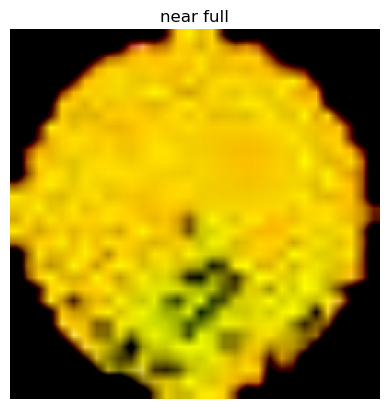

In [13]:
image_batch, label_batch = next(iter(train_loader))

image, label = image_batch[0], label_batch[0]

print(f"image shape:\t{image.shape}")
print(f"image label:\t{label} = {dataset.classes[label]}")

plt.imshow(image.permute(1,2,0)) # H, W, C
plt.title(dataset.classes[label])
plt.axis(False)

## ViT-Base

### Patch + Position Embedding (16x16)
- H = height
- W = width
- C = color channels
- P = patch size
- N = num of patches (= (H * W) / p^2)
- D = constant latent vector size (= embedding dimension)
<p>
    
Input: $H\times{W}\times{C}$
<p>
    
Output: ${N \times\left(P^{2}\cdot C\right)}$

In [14]:
height = 224
width = 224
color_channels = 3
patch_size = 16
number_of_patches = int((height * width) / patch_size**2)

print(f"Num of patches:\t{number_of_patches}")

Num of patches:	196


In [15]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image):\t{embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches):\t{embedding_layer_output_shape}")

Input shape (single 2D image):	(224, 224, 3)
Output shape (single 1D sequence of patches):	(196, 768)


### Visually creating patches by example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([3, 224, 224])


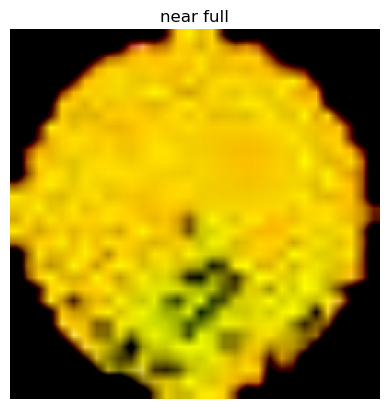

In [16]:
plt.imshow(image.permute(1,2,0))
plt.title(dataset.classes[label])
plt.axis(False);

print(image.shape) # H, W

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


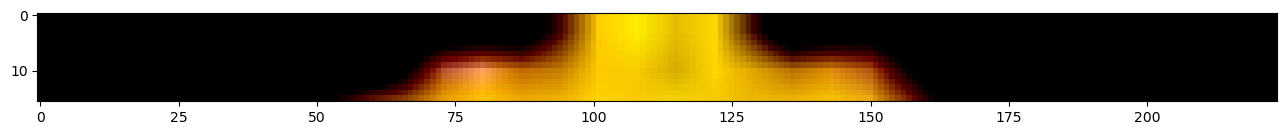

In [17]:
image_permuted = image.permute(1,2,0) # H, W, C

patch_size = 16

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.17647058].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.21568626].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.427451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..1.0].
Clipping input data to the v

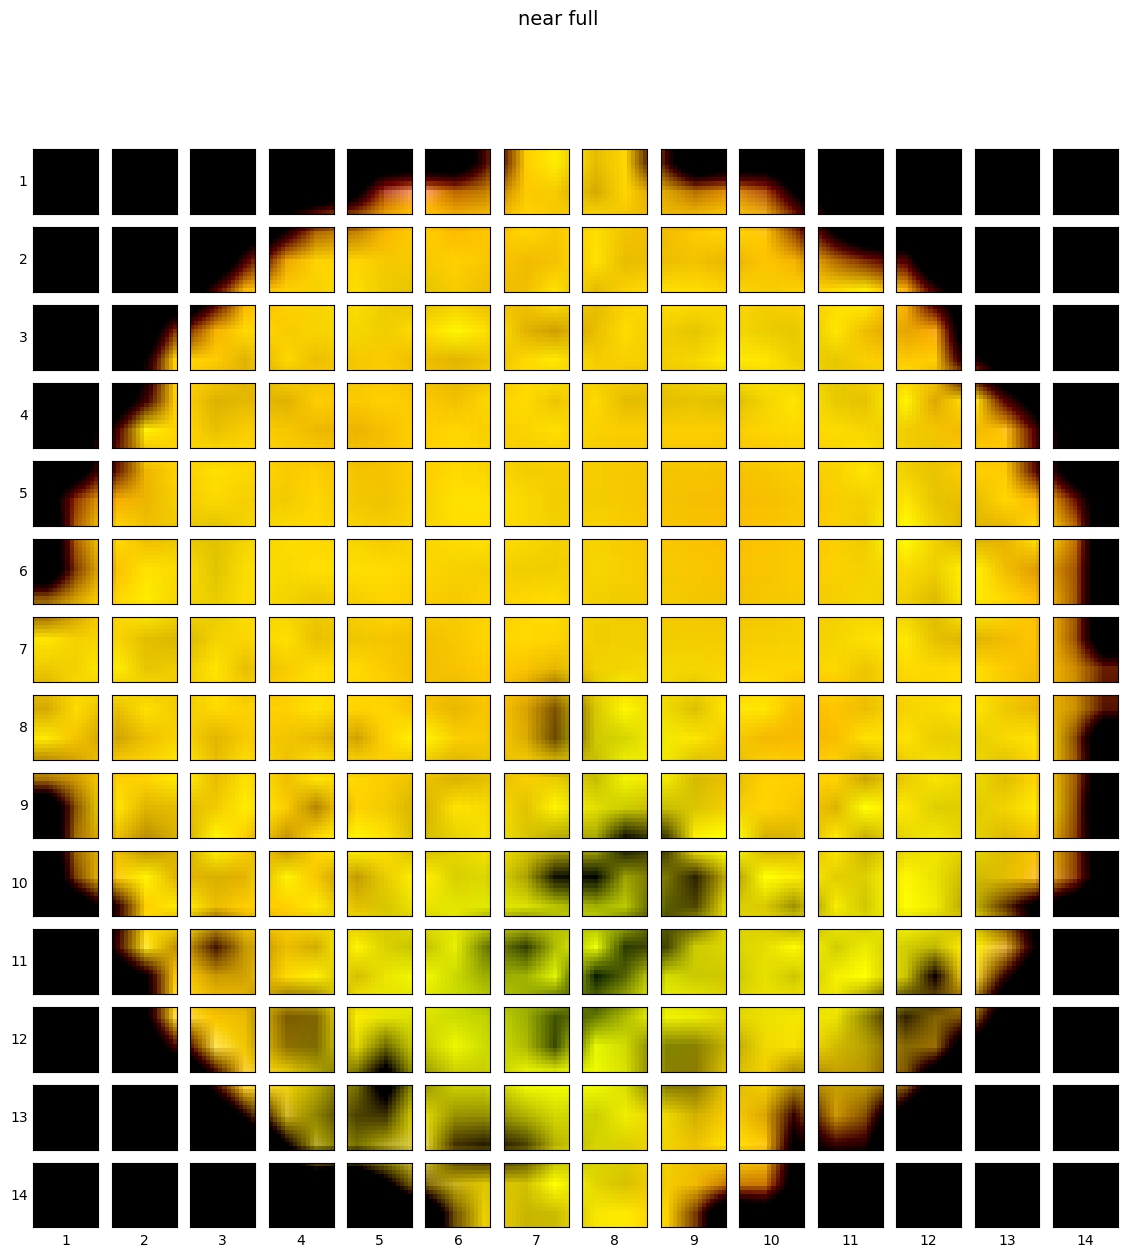

In [18]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0

fig, axs = plt.subplots(nrows=img_size // patch_size,
                       ncols=img_size // patch_size,
                       sharex=True, sharey=True,
                       figsize=(num_patches,
                                num_patches)
                      )

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size, :])
        axs[i,j].set_ylabel(i+1,
                           rotation="horizontal",
                           horizontalalignment="right",
                           verticalalignment="center")
        axs[i,j].set_xlabel(j+1)
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

fig.suptitle(f"{dataset.classes[label]}", fontsize=14)
plt.show();

### Embedding of image patches

In [22]:
patch_size = 16

conv2d = nn.Conv2d(
    in_channels=IN_CHANNELS,
    out_channels=OUT_CHANNELS,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


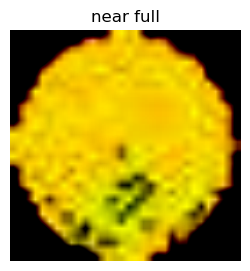

In [31]:
plt.figure(figsize=(3,3))

plt.imshow(image.permute(1,2,0))
plt.title(dataset.classes[label])
plt.axis(False)
plt.show();

In [43]:
# add batch dimension -> batch_size, embedding_dim, feature_map_height, feature_map_width
image_out_of_conv = conv2d(image.unsqueeze(0))

print(f"image shape:\t\t{image_out_of_conv.shape},\nbatch_size:\t\t{image_out_of_conv.shape[0]}\nembedding_dim:\t\t{image_out_of_conv.shape[1]}\nfeature_map_height:\t{image_out_of_conv.shape[2]}\nfeature_map_width:\t{image_out_of_conv.shape[3]}")

image shape:		torch.Size([1, 768, 14, 14]),
batch_size:		1
embedding_dim:		768
feature_map_height:	14
feature_map_width:	14


In [44]:
flatten_layer = nn.Flatten(start_dim=2,end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original image shape:			torch.Size([3, 224, 224])
Image feature map shape:		torch.Size([1, 768, 14, 14])
Flattened image feature map shape:	torch.Size([1, 768, 196])
Permuted flattened image feature map shape: torch.Size([1, 196, 768])


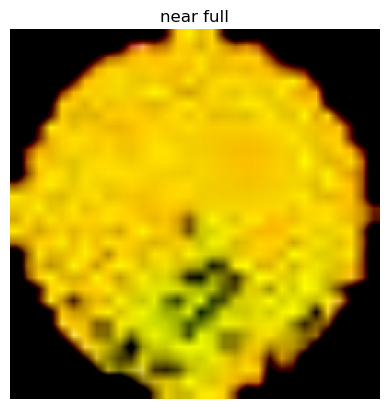

In [53]:
plt.imshow(image.permute(1,2,0))
plt.title(dataset.classes[label])
plt.axis(False)
print(f"Original image shape:\t\t\t{image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape:\t\t{image_out_of_conv.shape}")

image_out_of_conv_flatten = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape:\t{image_out_of_conv_flatten.shape}")
print(f"Permuted flattened image feature map shape: {image_out_of_conv_flatten.permute(0,2,1).shape}") # batch_size, num_patches, embedding_dim

In [58]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flatten.permute(0,2,1)

single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]

single_flattened_feature_map

tensor([[ 0.8100,  0.8149,  0.7318,  0.5757,  0.2244, -0.1975, -1.0418, -0.9917,
         -0.2195,  0.1004,  0.6672,  0.8222,  0.8506,  0.8583,  0.8248,  0.7180,
          0.3839, -0.7669, -1.0803, -1.1027, -1.0686, -1.0850, -1.0554, -1.0573,
         -0.3818,  0.3494,  0.8286,  0.8570,  0.7130,  0.4142, -0.8539, -1.1186,
         -1.0723, -1.0764, -1.0388, -1.0778, -1.1268, -1.1243, -1.0749, -0.8249,
          0.6588,  0.8362,  0.6423, -0.2833, -1.0610, -0.9961, -1.0580, -1.1025,
         -1.1019, -1.0672, -1.0329, -1.0932, -1.0587, -1.0203, -0.4566,  0.6424,
          0.3159, -0.9695, -1.1225, -1.1023, -1.1096, -1.1681, -1.1028, -1.0386,
         -1.0008, -1.0512, -1.1245, -1.0529, -0.9331,  0.1493, -0.0716, -1.1931,
         -1.0939, -1.1174, -1.1208, -1.1045, -1.0934, -1.0705, -1.0460, -1.0910,
         -1.1285, -1.0790, -0.9450, -0.2997, -1.0751, -1.1032, -1.0606, -1.0689,
         -1.0636, -1.0241, -1.0759, -1.0819, -1.0947, -1.1212, -1.1260, -1.0609,
         -0.9648, -0.4709, -

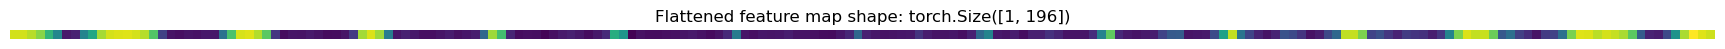

In [59]:
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [110]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()

        self.patch_size = patch_size
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

### Testing `PatchEmbedding` Class

In [109]:
set_seeds()

patch_embedding = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

print(f"Input image shape:\n\t{image.unsqueeze(0).shape}")

patch_embedded_image = patch_embedding(image.unsqueeze(0))

print(f"Ouput patch embedding sequence shape:\n\t{patch_embedded_image.shape}")

Input image shape:
	torch.Size([1, 3, 224, 224])
Ouput patch embedding sequence shape:
	torch.Size([1, 196, 768])


### Prepending a Learnable Class Token Embedding

In [112]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

batch_size, embedding_dim

(1, 768)

In [113]:
class_token = nn.Parameter(
    torch.ones(batch_size,1,embedding_dim),
    requires_grad=True
)

class_token.shape

torch.Size([1, 1, 768])

In [119]:
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image),
    dim=1
)

print(f"Tensor:\n\t{patch_embedded_image_with_class_embedding}\n")
print(f"Sequence of patch embeddings with class token prepended shape:\n\t{patch_embedded_image_with_class_embedding.shape}\n\t(batch_size, class_token + number_of_patches, embedding_dim)")

Tensor:
	tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.6443, -0.3031,  0.2042,  ..., -0.6183,  0.3268, -0.2081],
         [ 0.5950, -0.3237,  0.2300,  ..., -0.5325,  0.3315, -0.2262],
         ...,
         [ 0.6523, -0.2432,  0.0967,  ..., -0.6045,  0.4739, -0.2561],
         [ 0.7044, -0.3240,  0.1577,  ..., -0.4793,  0.3288, -0.2601],
         [ 0.6711, -0.3250,  0.3086,  ..., -0.5748,  0.2618, -0.2769]]],
       grad_fn=<CatBackward0>)

Sequence of patch embeddings with class token prepended shape:
	torch.Size([1, 197, 768])
	(batch_size, class_token + number_of_patches, embedding_dim)


### Positional Embedding

In [125]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.6443, -0.3031,  0.2042,  ..., -0.6183,  0.3268, -0.2081],
          [ 0.5950, -0.3237,  0.2300,  ..., -0.5325,  0.3315, -0.2262],
          ...,
          [ 0.6523, -0.2432,  0.0967,  ..., -0.6045,  0.4739, -0.2561],
          [ 0.7044, -0.3240,  0.1577,  ..., -0.4793,  0.3288, -0.2601],
          [ 0.6711, -0.3250,  0.3086,  ..., -0.5748,  0.2618, -0.2769]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [126]:
# Calculating N (num of patches)
num_of_patches = int((height * width) / patch_size**2)

# Embedding dimension
embedding_dim = patch_embedded_image_with_class_embedding.shape[-1]

# Learnable position embedding
position_embedding = nn.Parameter(
    torch.ones(1, num_of_patches+1,embedding_dim),
    requires_grad=True
)

print(f"Position embedding:\n\t{position_embedding}\nPosition embedding shape:\n\t{position_embedding.shape}")

Position embedding:
	Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)
Position embedding shape:
	torch.Size([1, 197, 768])


In [127]:
# Adding position embedding to patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(f"Patch and position embedding:\n\t{patch_and_position_embedding}\nPatch and position embedding shape:\n\t{patch_and_position_embedding.shape}")

Patch and position embedding:
	tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.6443, 0.6969, 1.2042,  ..., 0.3817, 1.3268, 0.7919],
         [1.5950, 0.6763, 1.2300,  ..., 0.4675, 1.3315, 0.7738],
         ...,
         [1.6523, 0.7568, 1.0967,  ..., 0.3955, 1.4739, 0.7439],
         [1.7044, 0.6760, 1.1577,  ..., 0.5207, 1.3288, 0.7399],
         [1.6711, 0.6750, 1.3086,  ..., 0.4252, 1.2618, 0.7231]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape:
	torch.Size([1, 197, 768])


### Image to Embedding <span style="color:red">(all in one cell)</span>

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

In [128]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# Pretrained model: ViT B 16

## 1a) Imports & Device setting

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1b) Config

In [90]:
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 10

## 2) Dataset Path & Transforms

In [91]:
data_dir = Path("../projects/wafer-cnn/data/WM811k_Dataset")

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

## 3) Dataset & Dataloaders

In [92]:
# Load dataset with ImageFolder
dataset = datasets.ImageFolder(root=str(data_dir), transform=transform)

# Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Wafer classes
print(f"Wafer classes: {dataset.class_to_idx}")

Wafer classes: {'Center': 0, 'Donut': 1, 'Edge Local': 2, 'Edge Ring': 3, 'Local': 4, 'Scratch': 5, 'near full': 6, 'none': 7, 'random': 8}


## 4) Load and Modify Pretrained ViT

In [93]:
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

# Replace classifier head
in_features = model.heads[0].in_features
# Number of wafer classes
num_wafer_classes = len(dataset.class_to_idx)

model.heads = nn.Linear(in_features, num_wafer_classes)

model = model.to(device)

## 5) Loss & Optimizer

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

## 6) Training & Validation Loops

In [99]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

## 7) Training Driver

In [100]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Log metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Get LR before scheduler step
    previous_lr = optimizer.param_groups[0]['lr']

    # Step scheduler based on validation loss
    scheduler.step(val_loss)

    # Get LR after step
    current_lr = optimizer.param_groups[0]['lr']

    # Optionally print if LR changed
    if current_lr != previous_lr:
        print(f"[INFO] Learning rate reduced: {previous_lr:.6f} → {current_lr:.6f}")

    # Always print training progress
    print(f"E {epoch+1}/{EPOCHS} | "
          f"LR {current_lr:.6f} | "
          f"Tr loss/acc {train_loss:.4f}/{train_acc:.4f} | "
          f"V loss/acc {val_loss:.4f}/{val_acc:.4f}")

E 1/10 | LR: 0.000100 | Tr loss/acc: 0.0464/0.9889 | V loss/acc: 0.2230/0.9282
E 2/10 | LR: 0.000100 | Tr loss/acc: 0.0455/0.9861 | V loss/acc: 0.2845/0.9116
E 3/10 | LR: 0.000100 | Tr loss/acc: 0.0344/0.9917 | V loss/acc: 0.7453/0.8122
[INFO] Learning rate reduced: 0.000100 → 0.000050
E 4/10 | LR: 0.000050 | Tr loss/acc: 0.0701/0.9750 | V loss/acc: 0.4117/0.8785
E 5/10 | LR: 0.000050 | Tr loss/acc: 0.0327/0.9903 | V loss/acc: 0.3084/0.9006
E 6/10 | LR: 0.000050 | Tr loss/acc: 0.0135/0.9972 | V loss/acc: 0.3553/0.9227
[INFO] Learning rate reduced: 0.000050 → 0.000025
E 7/10 | LR: 0.000025 | Tr loss/acc: 0.0038/1.0000 | V loss/acc: 0.3323/0.9227
E 8/10 | LR: 0.000025 | Tr loss/acc: 0.0020/1.0000 | V loss/acc: 0.3097/0.9227
E 9/10 | LR: 0.000025 | Tr loss/acc: 0.0018/1.0000 | V loss/acc: 0.3030/0.9227
[INFO] Learning rate reduced: 0.000025 → 0.000013
E 10/10 | LR: 0.000013 | Tr loss/acc: 0.0017/1.0000 | V loss/acc: 0.2989/0.9282


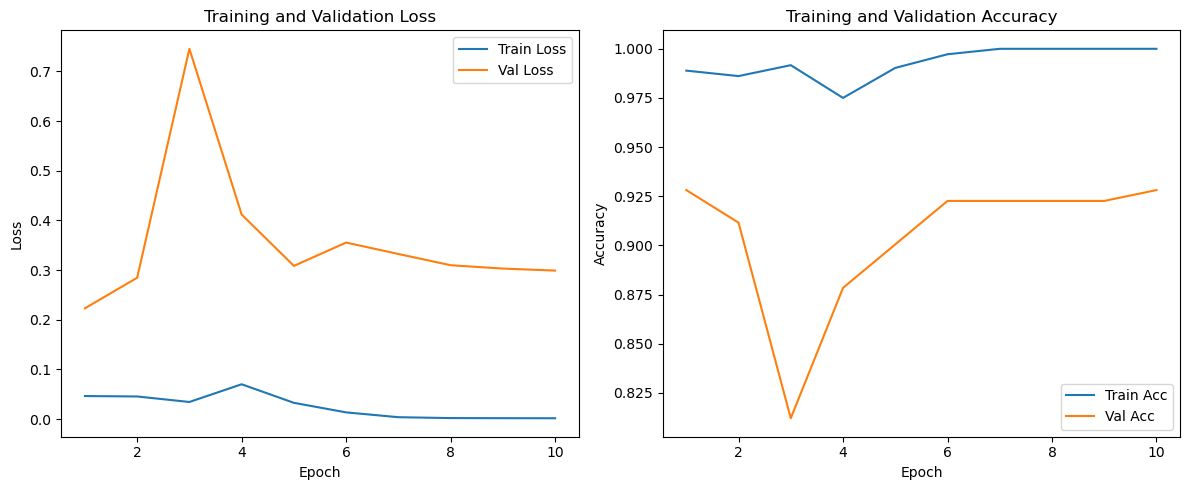

In [101]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [102]:
num_params = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters:     {num_params:,}")
print(f"Trainable parameters: {num_trainable:,}")

Total parameters:     85,805,577
Trainable parameters: 85,805,577


## 8) Save Model

In [ ]:
torch.save(model.state_dict(), "vit_wafer_model.pth")

In [76]:
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

num_wafer_classes = len(dataset.class_to_idx)
in_features = model.heads[0].in_features
model.heads = nn.Linear(in_features, num_wafer_classes)

print(f"Num of classes:\t{num_wafer_classes}\nModel:\t\t{model.heads}")

Num of classes:	9
Model:		Linear(in_features=768, out_features=9, bias=True)


In [63]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet means
        std=[0.229, 0.224, 0.225]    # ImageNet stds
    )
])

In [64]:
dataset.class_to_idx

{'Center': 0,
 'Donut': 1,
 'Edge Local': 2,
 'Edge Ring': 3,
 'Local': 4,
 'Scratch': 5,
 'near full': 6,
 'none': 7,
 'random': 8}